In [1]:
import pandas as pd

import io

# this is needed because misc.imread is deprecated
import imageio

# below needs this to run on terminal:  brew install graphviz
from sklearn.tree import export_graphviz

# weird! this needs to run both: conda install graphviz AND pip install graphviz
import graphviz

# requires:  conda install pydotplus
import pydotplus

In [2]:
# use encoding to avoid error "UnicodeDecodeError: 'utf-8' codec can't decode byte"
diabetes_data = pd.read_csv( 'diabetes.csv', encoding='latin-1' )

diabetes_data.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


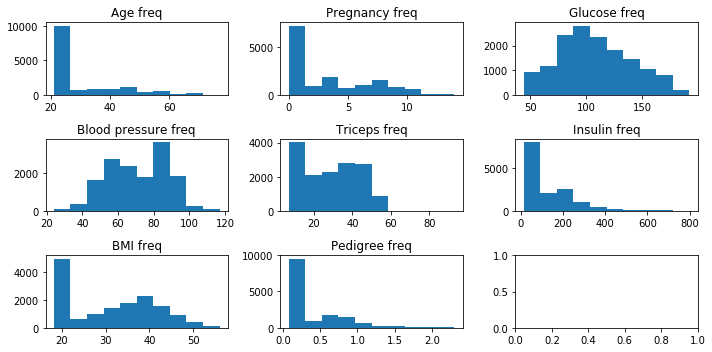

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

# plot histograms to reveal how the data is skewed

fig, axes = plt.subplots( nrows=3, ncols=3 )
( ageHist, pregHist, glucoseHist, bldPressHist, triThickHist
 , insulHist, bmiHist, pedigrHist, placeholder ) = axes.flatten()

fig.set_size_inches( 10, 5 )

ageHist.hist( diabetes_data[ "Age" ] )
ageHist.set_title( 'Age freq' )

pregHist.hist( diabetes_data[ "Pregnancies" ] )
pregHist.set_title( 'Pregnancy freq' )

glucoseHist.hist( diabetes_data[ "PlasmaGlucose" ] )
glucoseHist.set_title( 'Glucose freq' )

bldPressHist.hist( diabetes_data[ "DiastolicBloodPressure" ] )
bldPressHist.set_title( 'Blood pressure freq' )

triThickHist.hist( diabetes_data[ "TricepsThickness" ] )
triThickHist.set_title( 'Triceps freq' )

insulHist.hist( diabetes_data[ "SerumInsulin" ] )
insulHist.set_title( 'Insulin freq' )

bmiHist.hist( diabetes_data[ "BMI" ] )
bmiHist.set_title( 'BMI freq' )

pedigrHist.hist( diabetes_data[ "DiabetesPedigree" ] )
pedigrHist.set_title( 'Pedigree freq' )

plt.tight_layout()
plt.show()

In [4]:
# data has too many young people
# use log to flatten Age out a bit
import numpy as np
diabetes_data = diabetes_data.assign( log_Age = lambda x: 
                                 np.log( x[ 'Age' ] ) )

# apply zscore for other features:  glucose, blood pressure
# triceps thickness, insulin, BMI
from scipy.stats import zscore

diabetes_data = diabetes_data.assign( zscore_glucose = zscore( diabetes_data[ 'PlasmaGlucose' ] ) )
diabetes_data = diabetes_data.assign( zscore_pressure = zscore( diabetes_data[ 'DiastolicBloodPressure' ] ) )
diabetes_data = diabetes_data.assign( zscore_thick = zscore( diabetes_data[ 'TricepsThickness' ] ) )
diabetes_data = diabetes_data.assign( zscore_insulin = zscore( diabetes_data[ 'SerumInsulin' ] ) )
diabetes_data = diabetes_data.assign( zscore_bmi = zscore( diabetes_data[ 'BMI' ] ) )

# apply min-max for other features:  pregnancy, diabetes pedigree
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

minMaxData = pd.DataFrame( scaler.fit_transform( diabetes_data.loc[ :, [ 'Pregnancies','DiabetesPedigree' ] ] )
                         , columns = [ 'minMaxPreg', 'minMaxPedigree' ] )
diabetes_data = pd.concat( [ diabetes_data, minMaxData ], axis = 1, join = 'inner' )

diabetes_data.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,log_Age,zscore_glucose,zscore_pressure,zscore_thick,zscore_insulin,zscore_bmi,minMaxPreg,minMaxPedigree
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0,3.044522,1.974401,0.523884,0.356298,-0.863136,1.229683,0.000000,0.510511
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0,3.135494,-0.495823,1.299626,1.249448,-0.765438,-1.052302,0.571429,0.036123
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0,3.135494,0.223356,-1.445306,1.592967,-0.772953,1.024922,0.500000,0.000438
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1,3.761200,-0.151868,0.404539,-0.262036,1.248633,-0.197512,0.642857,0.541848
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0,3.091042,-0.714703,-0.729237,-0.124629,-0.772953,1.136926,0.071429,0.212047


In [5]:
# remove unneeded features
diabetes_copy = diabetes_data.copy(deep=True)
del diabetes_copy[ 'Age' ]
del diabetes_copy[ 'PlasmaGlucose' ]
del diabetes_copy[ 'DiastolicBloodPressure' ]
del diabetes_copy[ 'TricepsThickness' ]
del diabetes_copy[ 'SerumInsulin' ]
del diabetes_copy[ 'BMI' ]
del diabetes_copy[ 'DiabetesPedigree' ]
del diabetes_copy[ 'Pregnancies' ]
del diabetes_copy[ 'PatientID' ]

diabetes_copy.head()

,Diabetic,log_Age,zscore_glucose,zscore_pressure,zscore_thick,zscore_insulin,zscore_bmi,minMaxPreg,minMaxPedigree
0,0,3.044522,1.974401,0.523884,0.356298,-0.863136,1.229683,0.000000,0.510511
1,0,3.135494,-0.495823,1.299626,1.249448,-0.765438,-1.052302,0.571429,0.036123
2,0,3.135494,0.223356,-1.445306,1.592967,-0.772953,1.024922,0.500000,0.000438
3,1,3.761200,-0.151868,0.404539,-0.262036,1.248633,-0.197512,0.642857,0.541848
4,0,3.091042,-0.714703,-0.729237,-0.124629,-0.772953,1.136926,0.071429,0.212047


In [6]:
# split data into 70% training 30% testing
from sklearn.model_selection import train_test_split
train, test = train_test_split( diabetes_copy, test_size = 0.3 )

In [7]:
# select features to train and test
features = [ "log_Age", "zscore_glucose", "zscore_pressure", "zscore_thick"
            , "zscore_insulin", "zscore_bmi", "minMaxPreg", "minMaxPedigree" ]
X_train = train[ features ]
Y_train = train[ "Diabetic" ]
X_test = test[ features ]
Y_test = test[ "Diabetic" ]

In [8]:
# train a Boosted Decision tree model to predict Diabetic (0 or 1)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# this will create 200 weak learner decision trees and use them to build a strong classifier
bdt = AdaBoostClassifier( DecisionTreeClassifier( max_depth = 4 )
                         , algorithm="SAMME"
                         , n_estimators=200 )
dt = bdt.fit( X_train, Y_train )

In [9]:
from sklearn import tree
import graphviz 
%matplotlib inline
# modified function to handle ensemble instead of a single decision tree
def show_tree( theTree, features, width, height ):
    the_data = tree.export_graphviz( theTree, out_file = None, 
                             feature_names = features )
    
    # find first { in string
    indexDot = the_data.find( '{' )
    # hack to resize graph because kaggle doesn't have a way to change size on graphviz
    the_data = the_data[ : indexDot + 1 ] + '\n graph [size="%d,%d"]; ' % (width, height) + the_data[ indexDot + 1 : ]
    
    graph = graphviz.Source( the_data )
    return graph

def show_tree2( theTree, index, features, path ):
    f = io.StringIO() 
    export_graphviz( theTree[ index ], out_file=f, feature_names=features ) 
    pydotplus.graph_from_dot_data( f.getvalue() ).write_png( path )
    #img = misc.imread( path ) 
    img = imageio.imread( path )
    plt.rcParams[ "figure.figsize" ] = ( 20, 20 ) 
    plt.imshow( img )

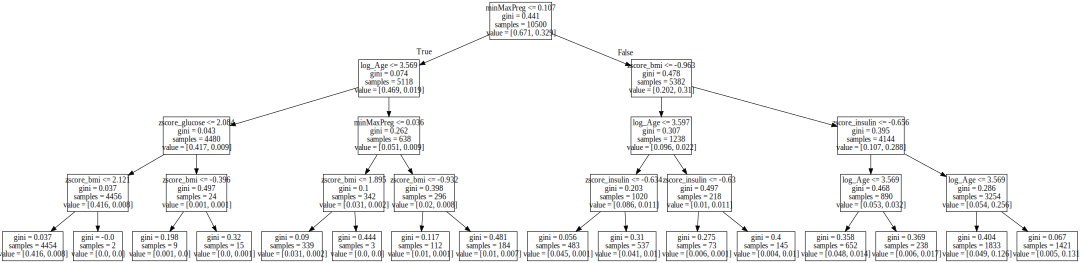

In [10]:
show_tree( dt[ 0 ], features, 15, 15 )

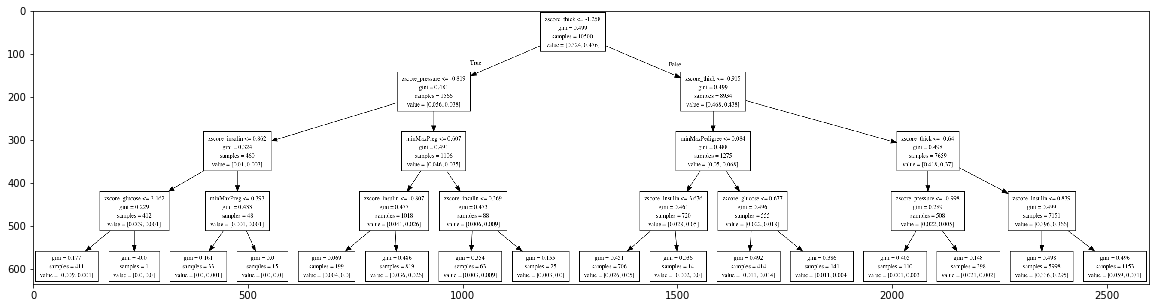

In [11]:
show_tree2( dt, 199, features, 'dec_tree_diabetes1.png' )

In [12]:
for name, importance in zip( X_train.columns, dt.feature_importances_ ):
    print( name, importance )

log_Age 0.1306101735450846
zscore_glucose 0.11062855152562306
zscore_pressure 0.09477947716755644
zscore_thick 0.11897197466157308
zscore_insulin 0.12814922745629811
zscore_bmi 0.1732576147986942
minMaxPreg 0.12143013755116877
minMaxPedigree 0.1221728432940015


In [13]:
def plot_feature_importances( decTree, trainingFeatures ):
    featureList = trainingFeatures.columns.values
    # sort both arrays by importance
    featureList = [ x for _, x in sorted( zip( decTree.feature_importances_, featureList ) ) ]
    featureSize = len( featureList )
    plt.barh( range( featureSize ), sorted( decTree.feature_importances_ ) )
    plt.ylabel( "Feature" )
    plt.yticks( np.arange( featureSize ), featureList )
    plt.xlabel( "Importance" )
    
from sklearn import model_selection

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure().set_size_inches( 5, 5 )
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def plot_ROC( falsePositiveRate, truePositiveRate, areaUnderCurve ):
    fig = plt.figure()
    fig.set_size_inches( 15, 5 )
    rocCurve = fig.add_subplot( 1, 2, 1 )

    rocCurve.plot( falsePositiveRate, truePositiveRate, color = 'darkgreen',
             lw = 2, label = 'ROC curve (area = %0.2f)' % areaUnderCurve )
    rocCurve.plot( [0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--' )
    rocCurve.grid()
    plt.xlim( [0.0, 1.0] )
    rocCurve.set_xticks( np.arange( -0.1, 1.0, 0.1 ) )
    plt.ylim( [0.0, 1.05] )
    rocCurve.set_yticks( np.arange( 0, 1.05, 0.1 ) )
    plt.xlabel( 'False Positive Rate' )
    plt.ylabel( 'True Positive Rate' )
    plt.title( 'ROC' )
    rocCurve.legend( loc = "lower right" )
    return plt

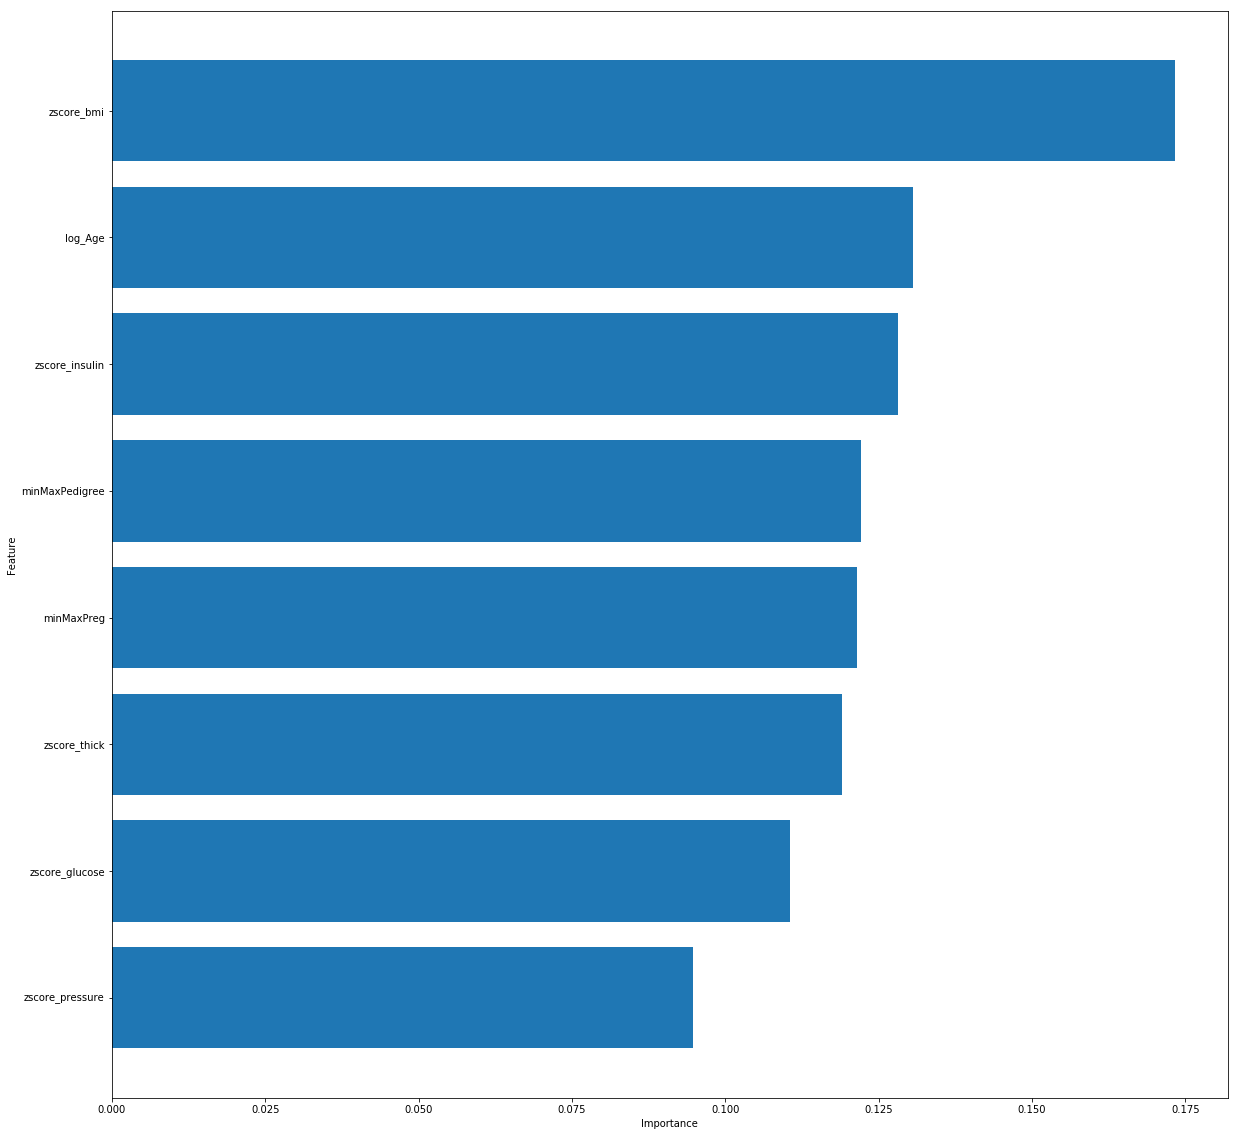

In [14]:
plot_feature_importances( dt, X_train )

In [15]:
Y_pred = dt.predict( X_test )
Y_probas = dt.predict_proba( X_test )

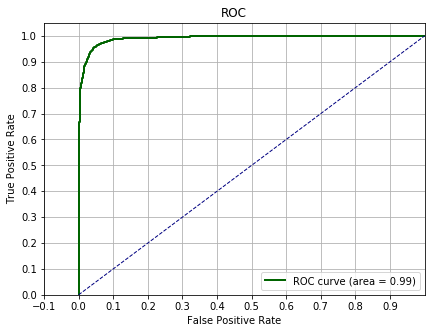

In [16]:
# see evaluation metrics

import numpy as np
from sklearn import metrics

# Receiver Operating Characteristic - precision/recall lift
# Y_probas[:,1] is the array of probabilities for Diabetic = 1 at the leaf level
fpr, tpr, thresholds = metrics.roc_curve( Y_test.values, Y_probas[:,1] )
auc = metrics.auc( fpr, tpr )

# plot ROC curve
plot_ROC( fpr, tpr, auc )
plt.show()



# alternative using scikitplot:  conda install -c conda-forge scikit-plot

#import scikitplot as skplt
#skplt.metrics.plot_roc_curve( Y_test, Y_probas )

In [17]:
# score the model on the test data

def scoreModel( Y_test, Y_pred ):
    # show accuracy, precision and recall
    from sklearn.metrics import accuracy_score
    score = accuracy_score( Y_test, Y_pred )
    print( "Accuracy: %.3f " % round( score, 3 ) )
    
    from sklearn.metrics import precision_score
    precScore = precision_score( Y_test, Y_pred, average = 'binary' )
    print( "Precision: %.3f " % round( precScore, 3 ) )
    
    from sklearn.metrics import recall_score
    recScore = recall_score( Y_test, Y_pred, average = 'binary' ) 
    print( "Recall: %.3f " % round( recScore, 3 ) )
    # confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix( Y_test, Y_pred )
    print( "True positives: %d  False negatives: %d" % ( cm[ 1, 1 ], cm[ 1, 0 ] ) )
    print( "False positives: %d  True negatives: %d" % ( cm[ 0, 1 ], cm[ 0, 0 ] ) )
    
    # AUC (area under the curve)
    auc = metrics.auc( fpr, tpr )
    print( "AUC: %.3f" % auc )

scoreModel( Y_test, Y_pred )

Accuracy: 0.953 
Precision: 0.937 
Recall: 0.926 
True positives: 1432  False negatives: 114
False positives: 97  True negatives: 2857
AUC: 0.991


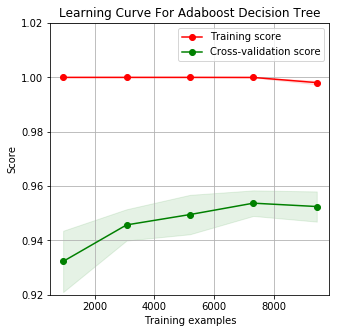

In [18]:

# this is to prevent 100s of DeprecationWarnings for something that is scheduled to
#  be fixed on the scikit-learn release of August 2018
from sklearn import preprocessing
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

theLearningCurve = plot_learning_curve( dt, 'Learning Curve For Adaboost Decision Tree', X_train, Y_train, ( 0.92, 1.02 ), 10 )
theLearningCurve.figure().set_size_inches( 5, 5 )
theLearningCurve.show()

In [19]:
# copied score of LightGBM using dart for comparison:
#      Accuracy: 0.953
#      Precision: 0.943  <- higher (more of the reported positives are true positives, that is, less false positives)
#      Recall: 0.910     <- lower (less true positives are reported as positives, that is, more false negatives)
#      True positives: 1342  False negatives: 132
#      False positives: 81  True negatives: 2945
#      AUC: 0.991
# less false positives, more false negatives, 
# less true positives, more true negatives

# score of LightGBM using gbdt:
#      Accuracy: 0.953 
#      Precision: 0.935 
#      Recall: 0.921 
#      True positives: 1357  False negatives: 117
#      False positives: 94  True negatives: 2932
#      AUC: 0.991

In [20]:
# TODO:  find a MART gradient boosting library
# install LightGBM:

# run brew install cmake
# brew install gcc
# (wait about 50 minutes for the above to complete)
# git clone --recursive https://github.com/Microsoft/LightGBM ; cd LightGBM
# export CXX=g++-7 CC=gcc-7
# mkdir build ; cd build
# cmake ..
# make -j4

# line below fails:  No module named 'lightgbm' unless fixed with:  
# conda config --add chanells conda-forge
# conda install lightgbm
import lightgbm as lgb

# create dataset for LightGBM
lgb_train = lgb.Dataset( X_train, Y_train )
lgb_eval = lgb.Dataset( X_test, Y_test, reference = lgb_train )

# configuration:  http://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {
    'task': 'train',
    'boosting_type': 'dart',
    # gbdt = Gradient Boosting Decision Tree
    # dart = Dropouts meet Multiple Additive Regression Trees 
    'objective': 'binary',
    'metric': { 'auc', 'root_mean_squared_error' },
    'max_depth': 4,
    'learning_rate': .5,
    'feature_fraction': 0.9,
    'bagging_fraction': 1,
    'bagging_freq': 0,  # no bagging
    'verbose': 0,
    'min_data_in_leaf': 20,  # adjust this to handle overfitting
    
    'num_machines': 1,   # can do parallel processing via network
    
    'device': 'cpu',   # can use GPUs via OpenCL
    'gpu_platform_id': -1,
    'gpu_device_id': -1
}

# http://lightgbm.readthedocs.io/en/latest/Python-API.html
gbm = lgb.train( params,
                lgb_train,
                num_boost_round = 200,
                valid_sets = lgb_eval,
                early_stopping_rounds = 5 )

Y_pred = gbm.predict( X_test, num_iteration = gbm.best_iteration )
#for name, importance in zip( X_train.columns, gbm.feature_importances_ ):
#    print( name, importance )

#from sklearn.metrics import mean_squared_error
#print( 'The rmse of prediction is:', mean_squared_error( Y_test, Y_pred ) ** 0.5 )

[1]	valid_0's rmse: 0.362754	valid_0's auc: 0.94059
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.312426	valid_0's auc: 0.955178
[3]	valid_0's rmse: 0.284232	valid_0's auc: 0.963638
[4]	valid_0's rmse: 0.258212	valid_0's auc: 0.972998
[5]	valid_0's rmse: 0.245798	valid_0's auc: 0.977199
[6]	valid_0's rmse: 0.236619	valid_0's auc: 0.979497
[7]	valid_0's rmse: 0.229267	valid_0's auc: 0.980989
[8]	valid_0's rmse: 0.229372	valid_0's auc: 0.981804
[9]	valid_0's rmse: 0.223239	valid_0's auc: 0.98305
[10]	valid_0's rmse: 0.214943	valid_0's auc: 0.984805
[11]	valid_0's rmse: 0.212036	valid_0's auc: 0.985619
[12]	valid_0's rmse: 0.213069	valid_0's auc: 0.985387
[13]	valid_0's rmse: 0.20913	valid_0's auc: 0.98614
[14]	valid_0's rmse: 0.206539	valid_0's auc: 0.986607
[15]	valid_0's rmse: 0.204589	valid_0's auc: 0.986966
[16]	valid_0's rmse: 0.199734	valid_0's auc: 0.987973
[17]	valid_0's rmse: 0.197124	valid_0's auc: 0.988517
[18]	valid_0's rmse: 0.194015	vali

In [21]:
scoreModel( Y_test, Y_pred.round() )

Accuracy: 0.960 
Precision: 0.943 
Recall: 0.940 
True positives: 1454  False negatives: 92
False positives: 88  True negatives: 2866
AUC: 0.991


In [22]:
# another way of using LightGBM
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt', 
                         max_depth = 4, 
                         learning_rate = 0.5, 
                         n_estimators = 200, 
                         objective = 'binary',
                         min_child_samples = 20 )

dt = gbm.fit( X_train, Y_train )

Y_pred = dt.predict( X_test )

Y_probas = gbm.predict_proba( X_test )



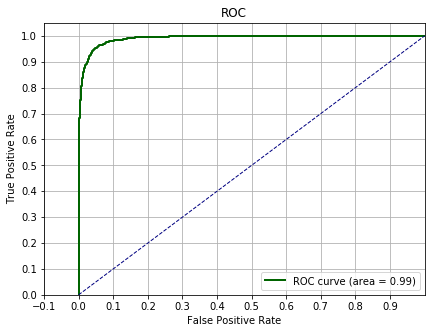

In [23]:

# Receiver Operating Characteristic - precision/recall lift
# Y_probas[:,1] is the array of probabilities for Diabetic = 1 at the leaf level
fpr, tpr, thresholds = metrics.roc_curve( Y_test, Y_probas[:,1] )
auc = metrics.auc( fpr, tpr )

# plot ROC curve
plot_ROC( fpr, tpr, auc )
plt.show()

In [24]:
scoreModel( Y_test, Y_pred )

Accuracy: 0.953 
Precision: 0.931 
Recall: 0.932 
True positives: 1441  False negatives: 105
False positives: 107  True negatives: 2847
AUC: 0.991


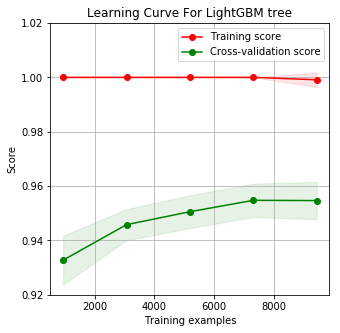

In [25]:


# this is to prevent 100s of DeprecationWarnings for something that is scheduled to
#  be fixed on the scikit-learn release of August 2018
from sklearn import preprocessing
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

theLearningCurve = plot_learning_curve( dt, 'Learning Curve For LightGBM tree', X_train, Y_train, ( 0.92, 1.02 ), 10 )
theLearningCurve.figure().set_size_inches( 5, 5 )
theLearningCurve.show()